# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_195  A2NJV5            22.873
Sample_090  P22692;P22692-2   15.542
Sample_002  Q96KR4;Q96KR4-3   15.101
Sample_198  P30041            15.573
Sample_015  P16083;Q5TD07     14.865
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                    
Sample_051  E5RHU3;E5RJB8;E7ESK6;E9PBI9;P34741   14.722
Sample_010  P01601                               16.620
Sample_105  P22676                                8.747
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.942
            A0A075B6Q5                 12.496
            A0A075B6R2                 10.925
            A0A075B6S5                 12.534
            A0A087WSY4                 12.508
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.113
            Q9UI40;Q9UI40-2            11.967
            Q9UIW2                     12.869
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.878
            Q9UP79                     13.252
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.275,15.050,16.842,19.863,15.878,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.787,19.067,...,15.528,15.576,14.157,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.788,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.667,17.705,17.039,16.163,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.684,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.475,15.345,17.084,18.708,14.249,19.433,11.027,11.087
Sample_207,15.739,16.877,15.469,16.898,15.181,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.494,13.555,13.413,13.644,12.928,11.963,12.418,13.988,13.303,13.323
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.687,19.067,16.127,...,12.147,12.938,12.857,12.775,11.016,12.011,13.204,12.837,11.997,13.567
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.420,13.615,13.237,12.756,12.438,12.225,12.961,11.864,13.106,14.504
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.028,13.205,12.041,13.436,13.538,12.792,12.867,13.001,10.950,13.872
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.899,12.235,12.943,13.254,12.503,13.863,12.345,11.599,13.420,13.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.501,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 167.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.17it/s]

100%|██████████| 3/3 [00:00<00:00,  5.12it/s]

100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.68it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.68it/s]

100%|██████████| 4/4 [00:00<00:00,  4.00it/s]

100%|██████████| 4/4 [00:00<00:00,  4.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.77it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.20it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.61it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.53it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.11it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.53it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.06it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.76it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.65it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.86it/s]

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.68it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.39it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.03it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.75it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.57it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.66it/s]

100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.45it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.14it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.61it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.91it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.13it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  2.97it/s]

100%|██████████| 9/9 [00:02<00:00,  3.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.54it/s]

 30%|███       | 3/10 [00:00<00:01,  5.62it/s]

 40%|████      | 4/10 [00:00<00:01,  4.86it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.20it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.17it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.70it/s]

100%|██████████| 10/10 [00:02<00:00,  2.89it/s]

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.06it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.07it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.33it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.01it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.30it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  2.93it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.77it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.01it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.17it/s]

100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

100%|██████████| 11/11 [00:03<00:00,  3.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.22it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.69it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.77it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.22it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.81it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.70it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.95it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.26it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.32it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.65it/s]

 31%|███       | 4/13 [00:00<00:01,  4.69it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.93it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.38it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.29it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.08it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.93it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.81it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.96it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.04it/s]

100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

100%|██████████| 13/13 [00:03<00:00,  3.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.61it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.88it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.04it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.19it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.93it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.20it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.95it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.11it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.07it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.14it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.27it/s]

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

100%|██████████| 14/14 [00:04<00:00,  3.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.39it/s]

 20%|██        | 3/15 [00:00<00:02,  4.74it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.66it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.11it/s]

 40%|████      | 6/15 [00:01<00:03,  2.64it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.43it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.72it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.01it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.23it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.33it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.56it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.73it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.86it/s]

100%|██████████| 15/15 [00:04<00:00,  3.81it/s]

100%|██████████| 15/15 [00:04<00:00,  3.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.051 0.024          0.814 0.296       0.139   
2             0.004 0.002      0.045 0.017          0.604 0.116       0.471   
3             0.005 0.002      0.054 0.018          0.807 0.077       0.723   
4             0.004 0.001      0.037 0.006          0.810 0.084       0.786   
5             0.004 0.001      0.044 0.016          0.843 0.072       0.812   
6             0.005 0.003      0.057 0.023          0.839 0.079       0.807   
7             0.004 0.002      0.041 0.013          0.843 0.077       0.813   
8             0.005 0.003      0.052 0.021          0.843 0.073       0.807   
9             0.004 0.002      0.043 0.015          0.843 0.074       0.841   
10            0.005 0.002      0.047 0.016          0.839 0.075       0.845   
11            0.004 0.002      0.046 0.016          0.839 0.075       0.836   
12            0.004 0.002      0.044 0.020          0.844 0.079       0.811   
13            0.005 0.003      0.050 0.019          0.844 0.077       0.804   
14            0.005 0.002      0.050 0.017          0.843 0.078       0.806   
15            0.006 0.003      0.054 0.021          0.848 0.073       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.230 0.128                  0.562 0.042        0.854   
2          0.120   0.519 0.098                  0.619 0.065        0.701   
3          0.103   0.758 0.072                  0.797 0.057        0.903   
4          0.104   0.793 0.069                  0.824 0.058        0.910   
5          0.090   0.823 0.060                  0.849 0.051        0.918   
6          0.096   0.818 0.066                  0.845 0.056        0.917   
7          0.087   0.823 0.058                  0.849 0.048        0.917   
8          0.092   0.822 0.066                  0.848 0.056        0.918   
9          0.092   0.839 0.065                  0.862 0.057        0.928   
10         0.096   0.838 0.068                  0.862 0.059        0.928   
11         0.103   0.834 0.069                  0.858 0.060        0.926   
12         0.093   0.824 0.068                  0.850 0.057        0.929   
13         0.095   0.819 0.065                  0.846 0.054        0.927   
14         0.098   0.820 0.067                  0.847 0.056        0.927   
15         0.101   0.822 0.067                  0.849 0.054        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.087        210.000 0.000  
2          0.081                  0.652 0.097        210.000 0.000  
3          0.046                  0.879 0.059        210.000 0.000  
4          0.045                  0.887 0.055        210.000 0.000  
5          0.046                  0.901 0.055        210.000 0.000  
6          0.048                  0.900 0.056        210.000 0.000  
7          0.047                  0.900 0.056        210.000 0.000  
8          0.046                  0.905 0.053        210.000 0.000  
9          0.043                  0.919 0.046        210.000 0.000  
10         0.044                  0.918 0.046        210.000 0.000  
11         0.045                  0.914 0.051        210.000 0.000  
12         0.044                  0.920 0.047        210.000 0.000  
13         0.045                  0.918 0.048        210.000 0.000  
14         0.044                  0.917 0.047        210.000 0.000  
15         0.045                  0.915 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 424.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.54it/s]

100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.50it/s]

100%|██████████| 4/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.64it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.99it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.43it/s]

100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

100%|██████████| 5/5 [00:01<00:00,  4.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.01it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.41it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.26it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.27it/s]

100%|██████████| 6/6 [00:01<00:00,  4.10it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.88it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.84it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.27it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.22it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.08it/s]

100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.36it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.10it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.59it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.55it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.42it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.27it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.40it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.75it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.39it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.16it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.13it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.02it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.92it/s]

100%|██████████| 9/9 [00:04<00:00,  1.95it/s]

100%|██████████| 9/9 [00:04<00:00,  2.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.73it/s]

 30%|███       | 3/10 [00:00<00:02,  2.92it/s]

 40%|████      | 4/10 [00:01<00:02,  2.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.03it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.06it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.08it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.06it/s]

100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.76it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.70it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.19it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.32it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.27it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.17it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.22it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.20it/s]

100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.81it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.59it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.40it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.10it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.03it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.01it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.97it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.97it/s]

100%|██████████| 12/12 [00:03<00:00,  2.99it/s]

100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.16it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.76it/s]

 31%|███       | 4/13 [00:01<00:02,  3.65it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.26it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.35it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.07it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.01it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.07it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.22it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.35it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.34it/s]

100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

100%|██████████| 13/13 [00:05<00:00,  2.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.63it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.23it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.02it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.83it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.70it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.85it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.86it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.97it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.78it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.78it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

100%|██████████| 14/14 [00:04<00:00,  2.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.28it/s]

 20%|██        | 3/15 [00:00<00:02,  5.20it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.36it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.08it/s]

 40%|████      | 6/15 [00:01<00:02,  3.84it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.64it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.63it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.30it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.78it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.61it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.49it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.64it/s]

100%|██████████| 15/15 [00:04<00:00,  2.84it/s]

100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.057 0.026          0.077 0.241       0.008   
2             0.006 0.003      0.064 0.029          0.492 0.391       0.105   
3             0.006 0.003      0.063 0.024          0.774 0.092       0.694   
4             0.005 0.002      0.048 0.016          0.773 0.085       0.706   
5             0.005 0.002      0.049 0.022          0.758 0.093       0.738   
6             0.004 0.001      0.038 0.009          0.776 0.094       0.741   
7             0.004 0.001      0.039 0.010          0.777 0.098       0.745   
8             0.003 0.000      0.033 0.005          0.776 0.101       0.734   
9             0.004 0.002      0.043 0.015          0.786 0.094       0.791   
10            0.005 0.002      0.051 0.019          0.797 0.087       0.800   
11            0.004 0.001      0.038 0.009          0.793 0.086       0.797   
12            0.006 0.003      0.059 0.025          0.797 0.089       0.805   
13            0.004 0.002      0.039 0.012          0.798 0.089       0.806   
14            0.005 0.003      0.053 0.020          0.800 0.087       0.796   
15            0.004 0.001      0.042 0.017          0.796 0.087       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.027   0.015 0.046                  0.500 0.013        0.866   
2          0.106   0.162 0.146                  0.531 0.042        0.759   
3          0.102   0.728 0.083                  0.773 0.065        0.884   
4          0.108   0.734 0.082                  0.777 0.063        0.881   
5          0.105   0.744 0.083                  0.782 0.069        0.882   
6          0.117   0.753 0.087                  0.792 0.071        0.887   
7          0.116   0.756 0.090                  0.793 0.075        0.889   
8          0.111   0.750 0.086                  0.788 0.071        0.888   
9          0.109   0.784 0.080                  0.816 0.068        0.905   
10         0.106   0.794 0.077                  0.825 0.065        0.905   
11         0.099   0.791 0.074                  0.821 0.063        0.915   
12         0.106   0.797 0.078                  0.826 0.068        0.918   
13         0.105   0.798 0.078                  0.827 0.068        0.918   
14         0.107   0.794 0.081                  0.824 0.069        0.919   
15         0.105   0.792 0.078                  0.822 0.067        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.832 0.087        210.000 0.000  
2          0.120                  0.717 0.137        210.000 0.000  
3          0.051                  0.857 0.061        210.000 0.000  
4          0.052                  0.853 0.063        210.000 0.000  
5          0.052                  0.861 0.058        210.000 0.000  
6          0.049                  0.865 0.058        210.000 0.000  
7          0.052                  0.867 0.060        210.000 0.000  
8          0.053                  0.866 0.061        210.000 0.000  
9          0.049                  0.879 0.059        210.000 0.000  
10         0.048                  0.876 0.060        210.000 0.000  
11         0.046                  0.892 0.055        210.000 0.000  
12         0.045                  0.898 0.053        210.000 0.000  
13         0.045                  0.897 0.053        210.000 0.000  
14         0.045                  0.900 0.053        210.000 0.000  
15         0.045                  0.897 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1079.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.93it/s]

100%|██████████| 3/3 [00:00<00:00, 26.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.36it/s]

100%|██████████| 4/4 [00:00<00:00, 14.50it/s]

100%|██████████| 4/4 [00:00<00:00, 14.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.02it/s]

100%|██████████| 5/5 [00:00<00:00, 15.73it/s]

100%|██████████| 5/5 [00:00<00:00, 16.13it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.28it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.06it/s]

100%|██████████| 6/6 [00:00<00:00, 12.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.27it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.56it/s]

100%|██████████| 7/7 [00:00<00:00, 15.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.96it/s]

 50%|█████     | 4/8 [00:00<00:00, 11.89it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.25it/s]

100%|██████████| 8/8 [00:00<00:00, 10.83it/s]

100%|██████████| 8/8 [00:00<00:00, 11.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.04it/s]

 44%|████▍     | 4/9 [00:00<00:00, 15.51it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.69it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.94it/s]

100%|██████████| 9/9 [00:00<00:00, 12.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.72it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.79it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.23it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.23it/s]

100%|██████████| 10/10 [00:00<00:00, 11.53it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.46it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.63it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.66it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.61it/s]

100%|██████████| 11/11 [00:00<00:00, 14.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.53it/s]

 42%|████▏     | 5/12 [00:00<00:00, 16.39it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 17.37it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 18.03it/s]

100%|██████████| 12/12 [00:00<00:00, 20.08it/s]

100%|██████████| 12/12 [00:00<00:00, 18.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.86it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.19it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.33it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.28it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.67it/s]

100%|██████████| 13/13 [00:00<00:00, 14.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.52it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.83it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.02it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.71it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 17.22it/s]

100%|██████████| 14/14 [00:00<00:00, 16.96it/s]

100%|██████████| 14/14 [00:00<00:00, 17.12it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.49it/s]

 40%|████      | 6/15 [00:00<00:00, 17.17it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.53it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.80it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.03it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.27it/s]

100%|██████████| 15/15 [00:01<00:00, 14.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.051 0.019          0.000 0.000       0.000   
2             0.004 0.002      0.044 0.016          0.648 0.114       0.475   
3             0.005 0.003      0.047 0.025          0.645 0.119       0.523   
4             0.004 0.001      0.039 0.012          0.658 0.102       0.594   
5             0.004 0.002      0.045 0.020          0.717 0.111       0.622   
6             0.005 0.003      0.046 0.018          0.741 0.098       0.633   
7             0.004 0.001      0.038 0.008          0.724 0.096       0.641   
8             0.005 0.002      0.047 0.015          0.716 0.107       0.645   
9             0.004 0.002      0.038 0.007          0.723 0.108       0.641   
10            0.005 0.002      0.044 0.015          0.715 0.105       0.631   
11            0.004 0.001      0.037 0.008          0.714 0.099       0.636   
12            0.005 0.002      0.043 0.020          0.730 0.097       0.638   
13            0.005 0.002      0.046 0.017          0.724 0.101       0.646   
14            0.007 0.004      0.068 0.037          0.728 0.090       0.652   
15            0.006 0.004      0.055 0.027          0.723 0.092       0.653   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.734   
2          0.103   0.542 0.094                  0.642 0.061        0.704   
3          0.108   0.571 0.095                  0.653 0.070        0.730   
4          0.109   0.619 0.090                  0.683 0.069        0.760   
5          0.112   0.661 0.092                  0.720 0.071        0.812   
6          0.109   0.678 0.085                  0.735 0.066        0.813   
7          0.107   0.674 0.081                  0.729 0.064        0.816   
8          0.112   0.673 0.091                  0.727 0.073        0.817   
9          0.116   0.674 0.095                  0.729 0.076        0.823   
10         0.110   0.665 0.091                  0.721 0.072        0.820   
11         0.103   0.667 0.083                  0.722 0.067        0.814   
12         0.110   0.674 0.081                  0.730 0.061        0.815   
13         0.108   0.675 0.082                  0.729 0.065        0.811   
14         0.108   0.682 0.081                  0.735 0.064        0.817   
15         0.104   0.681 0.079                  0.733 0.063        0.814   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.685 0.083        210.000 0.000  
2          0.077                  0.679 0.087        210.000 0.000  
3          0.069                  0.712 0.071        210.000 0.000  
4          0.067                  0.718 0.083        210.000 0.000  
5          0.068                  0.764 0.093        210.000 0.000  
6          0.069                  0.767 0.094        210.000 0.000  
7          0.068                  0.765 0.090        210.000 0.000  
8          0.066                  0.777 0.082        210.000 0.000  
9          0.066                  0.779 0.083        210.000 0.000  
10         0.066                  0.775 0.082        210.000 0.000  
11         0.065                  0.769 0.080        210.000 0.000  
12         0.062                  0.772 0.078        210.000 0.000  
13         0.064                  0.767 0.081        210.000 0.000  
14         0.061                  0.772 0.076        210.000 0.000  
15         0.061                  0.769 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,12,14
score_time,6,2,14
test_precision,15,14,6
test_recall,10,13,15
test_f1,9,13,14
test_balanced_accuracy,9,13,14
test_roc_auc,12,14,9
test_average_precision,12,14,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.92it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.40it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.69it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.48it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.46it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.65it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.36it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.20it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.14it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.39it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.34it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.48it/s]

100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 30.62it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 25.77it/s]

100%|██████████| 9/9 [00:00<00:00, 25.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.64it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.91it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.69it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.27it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.13it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.87it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.98it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.10it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


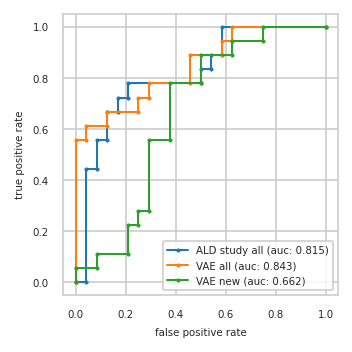

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.000 0.056
2          0.042 0.444   0.000 0.556   0.083 0.056
3          0.083 0.444   0.042 0.556   0.083 0.111
4          0.083 0.556   0.042 0.611   0.208 0.111
5          0.125 0.556   0.125 0.611   0.208 0.222
6          0.125 0.667   0.125 0.667   0.250 0.222
7          0.167 0.667   0.250 0.667   0.250 0.278
8          0.167 0.722   0.250 0.722   0.292 0.278
9          0.208 0.722   0.292 0.722   0.292 0.556
10         0.208 0.778   0.292 0.778   0.375 0.556
11         0.500 0.778   0.458 0.778   0.375 0.778
12         0.500 0.833   0.458 0.889   0.500 0.778
13         0.542 0.833   0.583 0.889   0.500 0.889
14         0.542 0.889   0.583 0.944   0.625 0.889
15         0.583 0.889   0.625 0.944   0.625 0.944
16         0.583 1.000   0.625 1.000   0.750 0.944
17         1.000 1.000   1.000 1.000   0.750 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,Q99983,P51688
2,B1AHL2;P23142-4,Q14315;Q14315-2,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
3,P61981,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P14174,P14174,P31321
5,P04075,P04075,P07900;P07900-2
6,Q9Y2T3;Q9Y2T3-3,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
7,Q99983,P61981,Q96GD0
8,P00338;P00338-3,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


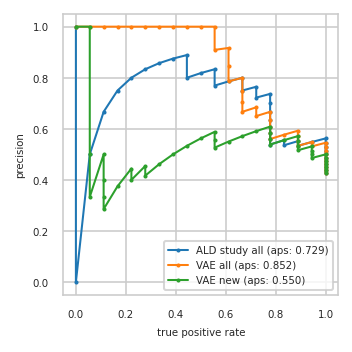

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.533 0.889     0.533 0.889     0.533 0.889
13         0.552 0.889     0.552 0.889     0.552 0.889
14         0.536 0.833     0.571 0.889     0.571 0.889
15         0.556 0.833     0.593 0.889     0.556 0.833
16         0.538 0.778     0.577 0.833     0.538 0.778
17         0.560 0.778     0.560 0.778     0.560 0.778
18         0.583 0.778     0.583 0.778     0.583 0.778
19         0.609 0.778     0.609 0.778     0.609 0.778
20         0.636 0.778     0.636 0.778     0.591 0.722
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.750 0.667     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.533 0.444
28         0.786 0.611     0.786 0.611     0.500 0.389
29         0.769 0.556     0.846 0.611     0.462 0.333
30         0.833 0.556     0.917 0.611     0.417 0.278
31         0.818 0.500     0.909 0.556     0.455 0.278
32         0.800 0.444     1.000 0.556     0.400 0.222
33         0.889 0.444     1.000 0.500     0.444 0.222
34         0.875 0.389     1.000 0.444     0.375 0.167
35         0.857 0.333     1.000 0.389     0.286 0.111
36         0.833 0.278     1.000 0.333     0.333 0.111
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


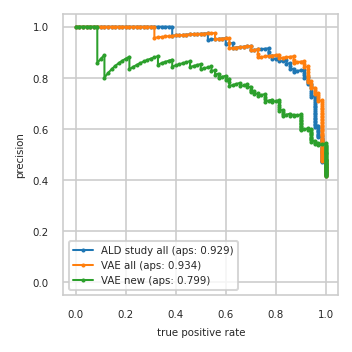

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


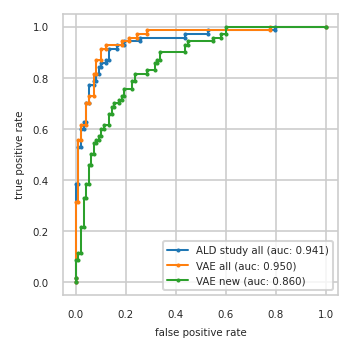

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}